# Fake News

En este norebook se realiza el proceso para analizar un conjunto de datos relacionados con múltiples noticias combinadas con fake news para hacer un estudio supervisado en el que se pueda obtener un aproximado de cómo identificar noticias falsas.

Este notebook se encuentra dividido en las siguientes secciones:

1. Carga de los datos
2. Entendimiento y limpieza de datos
3. Preparación de datos
4. Entrenamiento de un primer modelo
5. Entrenamiento de un segundo modelo
6. Entrenamiento de un tercer modelo
7. Resultados



## Caso

La distribución de noticias falsas sobre el tema de la política es una amenaza que puede afectar diferectamente las intituciones democráticas en términos de eficiencia y confiabilidad, donde también puede impactar la seguridad global.

En términos nacionales este tipo de noticias generan alteraciones importantes en votaciones electorales de los países democráticos donde se puedan implementar medias y políticas que afecten directamente los principios democráticos de cada país.

En el ámbito internacional puede generar tensiones diplomáticas que afecten directamente las decisiones que abarcan todo lo relacionado a política exterior y que tienen el objetivo de causar alguna estabilidad en función de los intereses presentados.

Al analizar esta situación un grupo independiente de académicos se dedicó a generar y almacenar noticias con el objetivo de que se puedan tomar medidas de detección de noticias falsas mediante filtros y segumiento de fuentes que sean viables.

## Los datos

En este caso se cuenta con un total de 60215 registros de noticias.

La descripción de los datos iniciales es la siguiente:

- ID (int): Id de la noticia.
- Label (int): Asignación sobre si la noticia es falsa o no.
- Título (char): Título de la noticia.
- Descripción (char): Descripción de la noticia.
- Fecha (date): Fecha de publicación de la noticia.


In [ ]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

!pip install ydata-profiling
from ydata_profiling import ProfileReport

## 1. Carga de los datos

In [ ]:
news_df = pd.read_csv('/content/fake_news_spanish_copy.csv', sep=';', encoding = "ISO-8859-1", on_bad_lines='skip')
news_df_copy = news_df

In [ ]:
news_df_copy.dtypes

,0
ID,object
Label,int64
Titulo,object
Descripcion,object
Fecha,object


In [ ]:
# Muestra de los datos
news_df_copy.sample(5)

,ID,Label,Titulo,Descripcion,Fecha
6796,ID,1,La Junta Electoral expedienta a la ministra po...,Isabel RodrÃ­guez censurÃ³ que el PP criticase...,04/05/2023
32661,ID,1,MÃ¡s Madrid propone homenajear a Javier MarÃ­a...,Entendemos que su talento literario es incuest...,11/09/2022
41300,ID,1,El Gobierno aprueba la ayuda de 10 millones a ...,El Consejo de Ministros da luz verde a un fond...,30/11/2020
18341,ID,1,"RodrÃ­guez Fraga, 35 aÃ±os como alcalde de uno...","El alcalde de Adeje, en el sur de Tenerife, ar...",13/05/2022
19284,ID,0,Unidas PP ultima una iniciativa en el Congreso...,PresentarÃ¡ una proposiciÃ³n no de ley durante...,14/05/2020


In [ ]:
from scipy import stats as st

contenido = news_df_copy.copy()
contenido['Conteo'] = [len(x) for x in contenido['Descripcion']]
contenido['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in contenido['Descripcion']]
contenido['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in contenido['Descripcion']]

In [ ]:
contenido

,ID,Label,Titulo,Descripcion,Fecha,Conteo,Max,Min
0,ID,1,'The Guardian' va con SÃ¡nchez: 'Europa necesi...,El diario britÃ¡nico publicÃ³ este pasado juev...,02/06/2023,221,13,1
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÃN...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÃN...,01/10/2023,3306,17,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en CastellÃ³ su fiest...,25/04/2022,172,14,2
3,ID,1,"Iglesias alienta a Yolanda DÃ­az, ERC y EH Bil...","En polÃ­tica, igual que hay que negociar con l...",03/01/2022,134,15,2
4,ID,0,Puigdemont: 'No serÃ­a ninguna tragedia una re...,"En una entrevista en El Punt Avui, el lÃ­der d...",09/03/2018,244,14,1
...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,251,13,1
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrÃ¡tica nos lleva a esa exi...,08/09/2020,320,12,1
57060,ID,1,Alberto GarzÃ³n: 'Que los Borbones son unos la...,El coordinador federal de IU asegura que la mo...,12/07/2018,72,11,2
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,234,12,1


1.1 Perfilamiento de datos

In [ ]:
news_df_copy.shape

(57063, 5)

In [ ]:
news_df_copy.describe()

,Label
count,57063.000000
mean,0.581077
std,0.493387
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
news_df_copy.dtypes

,0
ID,object
Label,int64
Titulo,object
Descripcion,object
Fecha,object


In [ ]:
profile_report = ProfileReport(news_df_copy, title="Pandas Profiling Report")
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **Unicidad**

Duplicados parciales

In [ ]:
num = news_df_copy.duplicated(subset="Descripcion").sum()
print(num)

7425


hay 7425 datos con la misma descripcion

# **Completitud**

In [ ]:
news_df_copy.isnull().sum()

,0
ID,0
Label,0
Titulo,16
Descripcion,0
Fecha,0


hay 16 titulos sin descripcion

In [ ]:
porcentajesLabel = news_df_copy['Label'].value_counts(normalize=True) * 100
print(porcentajesLabel)

Label
1    58.107706
0    41.892294
Name: proportion, dtype: float64


El 58% de todos los datos son verdaderos
El 42% de todos los datos falsos

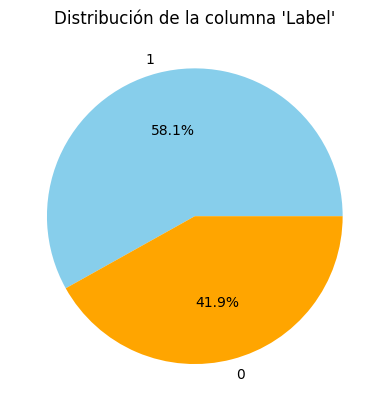

In [ ]:
# Visualizar distribución de label
news_df_copy['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'orange'])
plt.title("Distribución de la columna 'Label'")
plt.ylabel("")
plt.show()

In [ ]:
news_df_copy.nunique()

,0
ID,1
Label,2
Titulo,51604
Descripcion,49638
Fecha,2271


Registros unicos: 49638 de las descripciones registros son duplicados.
Hay títulos que comparten la misma descripcion

## 2. Preparación de los datos

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin

!pip install num2words
from num2words import num2words

from sklearn.feature_extraction.text import TfidfVectorizer

!pip install spacy
import spacy
!python -m spacy download es_core_news_sm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 40.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
class DataFrameCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_remove=None, subset_for_duplicates=None):
        self.columns_to_remove = columns_to_remove  # Columnas a eliminar
        self.subset_for_duplicates = subset_for_duplicates  # Columnas para identificar duplicados

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print(f"Tamaño inicial del DataFrame: {X.shape}")

        # Eliminar columnas que no se quieren
        if self.columns_to_remove:
            X = X.drop(columns=self.columns_to_remove, errors="ignore")
            print(f"Columnas eliminadas: {self.columns_to_remove}")

        # Eliminar registros duplicados
        if self.subset_for_duplicates:
            # Basarse en un subconjunto específico
            num_duplicados = X.duplicated(subset=self.subset_for_duplicates).sum()
        else:
            # Basarse en todas las columnas (por defecto)
            num_duplicados = X.duplicated().sum()

        print(f"Número de duplicados antes de limpiar: {num_duplicados}")

        # Eliminar duplicados
        if self.subset_for_duplicates:
            X = X.drop_duplicates(subset=self.subset_for_duplicates)
        else:
            X = X.drop_duplicates()

        # Recuento final de duplicados
        print(f"Número de duplicados después de limpiar: {X.duplicated().sum()}")

        # Imprimir tamaño final del DataFrame
        print(f"Tamaño final del DataFrame: {X.shape}")

        return X

In [ ]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('spanish'))

    def clean_text(self, text):
        # Reemplazar caracteres especiales
        text = text.replace('Ã±', 'ñ')
        text = text.replace('Ã¡', 'á')
        text = text.replace('Ã©', 'é')
        text = text.replace('Ã­', 'í')
        text = text.replace('Ã³', 'ó')
        text = text.replace('Ãº', 'ú')
        text = text.replace('Ã', 'a')
        text = text.replace('Ã©', 'e')
        text = text.replace('Ã­', 'i')
        text = text.replace('Ã³', 'o')
        text = text.replace('Ãº', 'u')

        # Convertir a minúsculas
        text = text.lower()

        # Eliminar números
        text = re.sub(r'\d+', '', text)

        # Eliminar símbolos y puntuación, pero mantener caracteres válidos en español
        text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', text)

        # Eliminar espacios adicionales
        text = re.sub(r'\s+', ' ', text).strip()

        # Eliminar stopwords
        words = text.split()
        words = [word for word in words if word not in self.stopwords]

        # Reconstruir el texto
        text = ' '.join(words)

        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self.clean_text)

In [ ]:
class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('spanish'))

    def tokenize(self, text):
        # Tokenizar el texto
        return nltk.word_tokenize(text)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Eliminar filas con valores nulos en X
        X = X.dropna()

        # Tokenizar cada texto en la serie
        return X.apply(self.tokenize)

In [ ]:
class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Cargar el modelo de spaCy para español
        self.nlp = spacy.load('es_core_news_sm')
        self.stopwords = set(stopwords.words('spanish'))

    def lemmatize_tokens(self, tokens):
        doc = self.nlp(' '.join(tokens))
        lemmatized_tokens = []

        for token in doc:
            # Verificar si el lema tiene más de una palabra
            if len(token.lemma_.split()) > 1:
                # Dividir el lema en palabras individuales
                for word in token.lemma_.split():
                    # Añadir la palabra si no es una stopword
                    if word not in self.stopwords:
                        lemmatized_tokens.append(word)
            else:
                lemmatized_tokens.append(token.lemma_)

        return lemmatized_tokens

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Aplica la lematización a cada lista de tokens en la serie
        return X.apply(lambda tokens: self.lemmatize_tokens(tokens))

In [ ]:
from sklearn.pipeline import Pipeline

def identity_tokenizer(tokens):
    return tokens

def identity_preprocessor(text):
    return text

pipeline = Pipeline([
    ('df_cleaner', DataFrameCleaner(columns_to_remove=['ID', 'Fecha'])),
    ('cleaner', DataCleaner()),        # Limpieza de datos
    ('tokenizer', Tokenizer()),        # Tokenización y eliminación de nulos
    ('normalizer', Normalizer()),      # Lematización de tokens
    ('tfidf', TfidfVectorizer(tokenizer= identity_tokenizer, preprocessor= identity_preprocessor)),  # Vectorización TF-IDF
])
pipeline

Pipeline(steps=[('df_cleaner',
                 DataFrameCleaner(columns_to_remove=['ID', 'Fecha'])),
                ('cleaner', DataCleaner()), ('tokenizer', Tokenizer()),
                ('normalizer', Normalizer()),
                ('tfidf',
                 TfidfVectorizer(preprocessor=<function identity_preprocessor at 0x7ae82e1e62a0>,
                                 tokenizer=<function identity_tokenizer at 0x7ae82e1e5940>))])

In [ ]:
# Aplicar el pipeline sobre el DataFrame 'news_df'
news_df_cleaned = pipeline.named_steps['df_cleaner'].fit_transform(news_df)

# Ver los datos limpios después del primer paso
print(news_df_cleaned.head())

Tamaño inicial del DataFrame: (57063, 5)
Columnas eliminadas: ['ID', 'Fecha']
Número de duplicados antes de limpiar: 449
Número de duplicados después de limpiar: 0
Tamaño final del DataFrame: (56614, 3)
   Label                                             Titulo  \
0      1  'The Guardian' va con SÃ¡nchez: 'Europa necesi...   
1      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÃN...   
2      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3      1  Iglesias alienta a Yolanda DÃ­az, ERC y EH Bil...   
4      0  Puigdemont: 'No serÃ­a ninguna tragedia una re...   

                                         Descripcion  
0  El diario britÃ¡nico publicÃ³ este pasado juev...  
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÃN...  
2  El valencianismo convoca en CastellÃ³ su fiest...  
3  En polÃ­tica, igual que hay que negociar con l...  
4  En una entrevista en El Punt Avui, el lÃ­der d...  


In [ ]:
news_df_copy['Descripcion'].iloc[0]

'El diario britÃ¡nico publicÃ³ este pasado jueves un editorial sobre las prÃ³ximas elecciones del 23J en el que califica de valiente el adelanto electoral y apoya que el presidente alerte de los riesgos de la ultraderecha.'

In [ ]:
news_cleaned = pipeline.named_steps['cleaner'].transform(news_df_cleaned['Descripcion'])
news_cleaned.iloc[0]

'diario británico publicó pasado jueves editorial próximas elecciones j califica valiente adelanto electoral apoya presidente alerte riesgos ultraderecha'

In [ ]:
news_cleaned.iloc[0]

'diario británico publicó pasado jueves editorial próximas elecciones j califica valiente adelanto electoral apoya presidente alerte riesgos ultraderecha'

In [ ]:
news_tokenized = pipeline.named_steps['tokenizer'].transform(news_cleaned)
news_tokenized.iloc[0]

['diario',
 'británico',
 'publicó',
 'pasado',
 'jueves',
 'editorial',
 'próximas',
 'elecciones',
 'j',
 'califica',
 'valiente',
 'adelanto',
 'electoral',
 'apoya',
 'presidente',
 'alerte',
 'riesgos',
 'ultraderecha']

In [ ]:
news_tokenized.iloc[0]

['diario',
 'británico',
 'publicó',
 'pasado',
 'jueves',
 'editorial',
 'próximas',
 'elecciones',
 'j',
 'califica',
 'valiente',
 'adelanto',
 'electoral',
 'apoya',
 'presidente',
 'alerte',
 'riesgos',
 'ultraderecha']

In [ ]:
news_normalized = pipeline.named_steps['normalizer'].transform(news_tokenized)
news_normalized.iloc[0]

['diario',
 'británico',
 'publicar',
 'pasado',
 'jueves',
 'editorial',
 'próximo',
 'elección',
 'j',
 'calificar',
 'valiente',
 'adelanto',
 'electoral',
 'apoyar',
 'presidente',
 'alertir',
 'riesgo',
 'ultraderecho']

In [ ]:
news_normalized.iloc[0]

['diario',
 'británico',
 'publicar',
 'pasado',
 'jueves',
 'editorial',
 'próximo',
 'elección',
 'j',
 'calificar',
 'valiente',
 'adelanto',
 'electoral',
 'apoyar',
 'presidente',
 'alertir',
 'riesgo',
 'ultraderecho']

In [ ]:
X_transformed = pipeline.named_steps['tfidf'].fit_transform(news_normalized)
print(X_transformed[:5])
print(X_transformed.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


  (0, 10417)	0.2303338756680639
  (0, 4701)	0.27263746678412637
  (0, 26070)	0.21642226900191713
  (0, 23702)	0.1657266465085628
  (0, 18654)	0.18284368831207473
  (0, 11320)	0.3100440792426739
  (0, 25999)	0.15835216972785204
  (0, 11478)	0.14896379960375603
  (0, 18389)	0.3009809185187437
  (0, 5045)	0.22460453108337286
  (0, 32452)	0.2876710098292584
  (0, 615)	0.2547881550940596
  (0, 11487)	0.1595260048795354
  (0, 2379)	0.19028799386147802
  (0, 25385)	0.11953129415442147
  (0, 1339)	0.39660780517471844
  (0, 28184)	0.21994303197080625
  (0, 32110)	0.22618492596668524
  (1, 25385)	0.017762591362336554
  (1, 28037)	0.1366830988679452
  (1, 15493)	0.08692726706522308
  (1, 22242)	0.03627999046345639
  (1, 19354)	0.06114011889535491
  (1, 21303)	0.5304304769592434
  (1, 5115)	0.053021074323261065
  :	:
  (3, 23620)	0.22714664383195007
  (3, 27145)	0.5118241649963494
  (3, 16721)	0.25788153801230534
  (4, 11478)	0.12422563192864566
  (4, 25004)	0.15619631861085181
  (4, 12266)	0.1627

In [ ]:
terms = pipeline.named_steps['tfidf'].get_feature_names_out()
print(terms[10904])

djokovic


In [ ]:
print(terms[600:630])

['adecuación' 'adecuadamente' 'adecuado' 'adecuar' 'adecúa' 'adejar'
 'adeje' 'adelanta' 'adelantado' 'adelantar' 'adelantarir' 'adelantarlas'
 'adelante' 'adelantees' 'adelantir' 'adelanto' 'adelgazado' 'adelgazar'
 'adema' 'ademar' 'ademán' 'además' 'adena' 'adendo' 'adentrar' 'adepto'
 'aderezado' 'aderezo' 'adeudado' 'adeudo']


In [ ]:
print(X_transformed[:, 3])

  (628, 0)	0.2727019331965623
  (1242, 0)	0.2760040702559355
  (3866, 0)	0.2727019331965623
  (13019, 0)	0.2926783265706362
  (54545, 0)	0.28982686706635796


# 3. Modelado de los datos

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [ ]:
pipeline_neural_net = Pipeline([
    ('cleaner', DataCleaner()),        # Limpieza de datos
    ('tokenizer', Tokenizer()),        # Tokenización y eliminación de nulos
    ('normalizer', Normalizer()),      # Lematización de tokens
    ('tfidf', TfidfVectorizer(tokenizer= identity_tokenizer, preprocessor= identity_preprocessor)),  # Vectorización TF-IDF
    ('classifier', MLPClassifier(activation= 'logistic',
                                 alpha= 0.008065429868602328,
                                 hidden_layer_sizes= (150,),
                                 learning_rate= 'constant',
                                 max_iter= 220,
                                 solver= 'lbfgs'))  # Red neuronal simple
])

X = news_df['Descripcion']
y = news_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_neural_net.fit(X_train, y_train)

y_pred = pipeline_neural_net.predict(X_test)

results_df = pd.DataFrame({
    'Opinión': X_test,
    'Predicción': y_pred
})
results_df


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,Opinión,Predicción
4800,El secretario de OrganizaciÃ³n del PSOE recuer...,1
21368,El expresidente del Gobierno ha asegurado que ...,0
48307,El presidente del Gobierno aboga por una recup...,0
16261,Considera que el consistorio no fue ni ofendid...,1
50467,"Cedo esa trinchera, afirma el letrado Xavier M...",1
...,...,...
56199,La Audiencia Provincial ha archivado la pieza ...,1
48475,El letrado de la AdministraciÃ³n puso en cuest...,1
51985,Concretar âlos instrumentosâ para la negoc...,0
55909,PÃºblico acompaÃ±a a la delegaciÃ³n de eurodip...,0


In [ ]:
pipeline_naive_bayes = Pipeline([
    ('cleaner', DataCleaner()),        # Limpieza de datos
    ('tokenizer', Tokenizer()),        # Tokenización y eliminación de nulos
    ('normalizer', Normalizer()),      # Lematización de tokens
    ('tfidf', TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)),  # Vectorización TF-IDF
    ('classifier', MultinomialNB(alpha= 0.1, fit_prior=True))  # Clasificador Naive Bayes
])

# entrenamiento
pipeline_naive_bayes.fit(X_train, y_train)

# predicciones
y_pred = pipeline_naive_bayes.predict(X_test)

#  DataFrame con las predicciones
results_df = pd.DataFrame({
    'Opinión': X_test,
    'Predicción': y_pred
})
print(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


                                                 Opinión  Predicción
4800   El secretario de OrganizaciÃ³n del PSOE recuer...           1
21368  El expresidente del Gobierno ha asegurado que ...           0
48307  El presidente del Gobierno aboga por una recup...           1
16261  Considera que el consistorio no fue ni ofendid...           1
50467  Cedo esa trinchera, afirma el letrado Xavier M...           0
...                                                  ...         ...
56199  La Audiencia Provincial ha archivado la pieza ...           1
48475  El letrado de la AdministraciÃ³n puso en cuest...           1
51985  Concretar âlos instrumentosâ para la negoc...           0
55909  PÃºblico acompaÃ±a a la delegaciÃ³n de eurodip...           0
7094   Algunos expertos en Derecho Constitucional apu...           1

[11413 rows x 2 columns]


In [ ]:
r2 = r2_score(y_test, y_pred)
r2

-0.34913933502199823

# 3.1 Santiago Celis - Algoritmo KNN

En esta sección, implementamos el algoritmo de clasificación basado en K-vecinos utilizando la documentación de scikit-learn. Los pasos incluirán la preparación de los datos transformados, la evaluación del modelo con diferentes valores de K, y la elección del mejor modelo basado en métricas de rendimiento.

## 3.1.1 Preparación de los datos
Para preparar los datos, utilizaremos el resultado del pipeline de limpieza y normalización visto previamente, aplicando la vectorización Tfidf para convertir los textos en una representación matricial numérica. También dividiremos los datos en conjuntos de entrenamiento y prueba.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Extraer características (texto) y etiquetas (labels)
X = news_df['Descripcion']  # Descripción (cuerpo de las noticias)
y = news_df['Label']        # Etiqueta: 1 (Verdadero), 0 (Falso)

# Vectorización del texto utilizando Tfidf
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Tamaño del conjunto de entrenamiento: (45650, 170)
Tamaño del conjunto de prueba: (11413, 170)


## 3.1.2 Evaluación con diferentes valores de K
Para determinar el mejor número de vecinos (K), evaluaremos el modelo con varios valores de k utilizando validación cruzada. Esta validación cruzada proporciona una métrica robusta para evaluar el rendimiento del modelo en datos no vistos.

In [ ]:
# Función para evaluar un modelo KNN dado el número de vecinos
def evaluar_knn(k, X, y):
    knn = KNeighborsClassifier(n_neighbors=k)
    try:
        scores = cross_val_score(knn, X, y, cv=5)
        print(f"Cross-validation scores (k={k}): {scores}")
        print(f"Mean accuracy (k={k}): {np.mean(scores):.4f}")
    except ValueError as e:
        print(f"Error al evaluar KNN con k={k}: {e}")

# Evaluar KNN con diferentes valores de K, en este caso se probó solo con 3, 7 y 9 pero se probaron con varios valores
for k in [3, 7, 9]:
    evaluar_knn(k, X_tfidf, y)

Cross-validation scores (k=3): [0.44834837 0.4498379  0.45211601 0.44383106 0.44497021]
Mean accuracy (k=3): 0.4478
Cross-validation scores (k=7): [0.5470078  0.54692018 0.55261544 0.55152471 0.54425166]
Mean accuracy (k=7): 0.5485
Cross-validation scores (k=9): [0.56567073 0.56260405 0.57530886 0.57316859 0.56554504]
Mean accuracy (k=9): 0.5685


## 3.1.3 Entrenamiento del modelo con el mejor valor de K

Basándonos en las evaluaciones anteriores, seleccionaremos el mejor valor de K (en este caso, 9) y entrenaremos el modelo utilizando el conjunto de entrenamiento. Posteriormente, evaluaremos el rendimiento en el conjunto de prueba.

In [ ]:
# Entrenamiento del modelo con K=9
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred = knn.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo (k=9): {accuracy:.4f}")

# Reporte detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Accuracy del modelo (k=9): 0.5714

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.49      0.39      0.43      4808
           1       0.61      0.70      0.66      6605

    accuracy                           0.57     11413
   macro avg       0.55      0.55      0.54     11413
weighted avg       0.56      0.57      0.56     11413



## 3.1.4 Visualización con Matriz de Confusión

Finalmente, presentamos la matriz de confusión para visualizar el rendimiento del modelo sobre el conjunto de prueba. Esto nos permite identificar los verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.

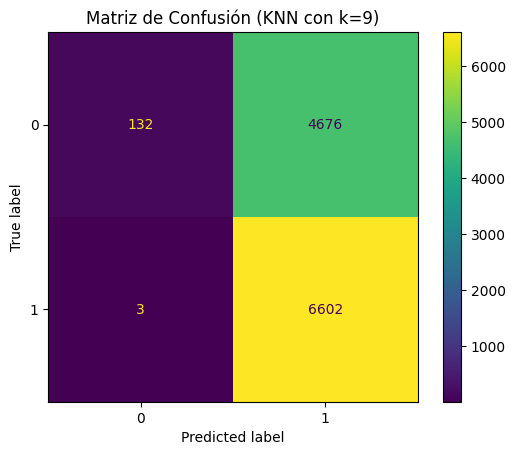

In [ ]:
# Generar la matriz de confusión y mostrarla
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.ax_.set_title('Matriz de Confusión (KNN con k=9)')
plt.show()

Entrenamos el clasificador KNN con el número de vecinos optimizado y evaluamos su desempeño.

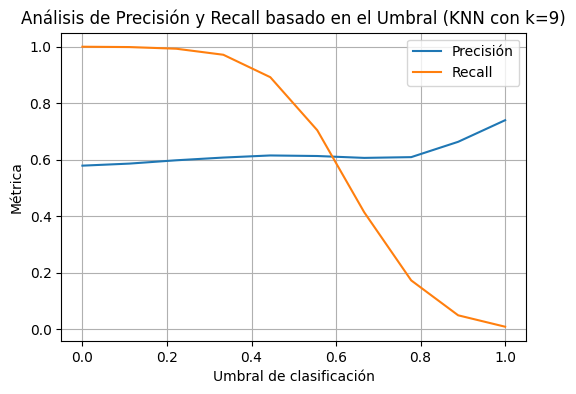

In [ ]:
from sklearn.metrics import precision_recall_curve

# Probabilidades de predicción obtenidas con predict_proba
y_prob = knn.predict_proba(X_test)[:, 1]  # Probabilidad de ser '1' (Verdadero)

# Calcular precisión, recall y thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Graficar precisión vs recall con respecto a los thresholds
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions[:-1], label="Precisión")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.title("Análisis de Precisión y Recall basado en el Umbral (KNN con k=9)")
plt.legend()
plt.grid()
plt.show()

Generamos la matriz de confusión para proporcionar una visión clara de las predicciones correctas (verdaderos positivos y negativos) y los errores cometidos (falsos positivos y negativos).

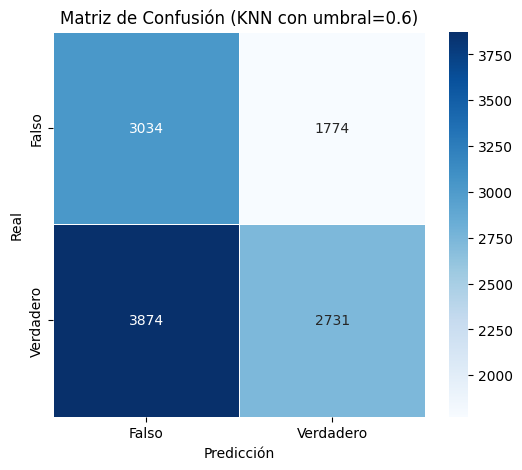

Exactitud con el nuevo umbral: 0.5051

Reporte de Clasificación con umbral ajustado:
              precision    recall  f1-score   support

           0       0.44      0.63      0.52      4808
           1       0.61      0.41      0.49      6605

    accuracy                           0.51     11413
   macro avg       0.52      0.52      0.50     11413
weighted avg       0.54      0.51      0.50     11413



In [ ]:
# Importar confusion_matrix desde sklearn.metrics
from sklearn.metrics import confusion_matrix
# Ajustar el umbral al punto de equilibrio seleccionado (por ejemplo, 0.6)
optimal_threshold = 0.6

# Generar nuevas predicciones basadas en el umbral ajustado
y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)

# Matriz de confusión para el nuevo umbral
matrix_nuevo = confusion_matrix(y_test, y_pred_adjusted)

# Visualizar la matriz de confusión ajustada
plt.figure(figsize=(6, 5))
sns.heatmap(matrix_nuevo, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Falso', 'Verdadero'], yticklabels=['Falso', 'Verdadero'], linewidths=0.5)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión (KNN con umbral={optimal_threshold})')
plt.show()

# Evaluación con el nuevo umbral
accuracy_nueva = accuracy_score(y_test, y_pred_adjusted)
print(f"Exactitud con el nuevo umbral: {accuracy_nueva:.4f}")

print("\nReporte de Clasificación con umbral ajustado:")
print(classification_report(y_test, y_pred_adjusted))

# 3.2 Luis Borbon Holguin
**Algoritmo de Arboles de Decisión**

Matriz de confusión para definir el umbral


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, ConfusionMatrixDisplay,precision_recall_curve
matrix = confusion_matrix(y_test, y_pred)
matrix_nueva = confusion_matrix(y_test, y_pred)


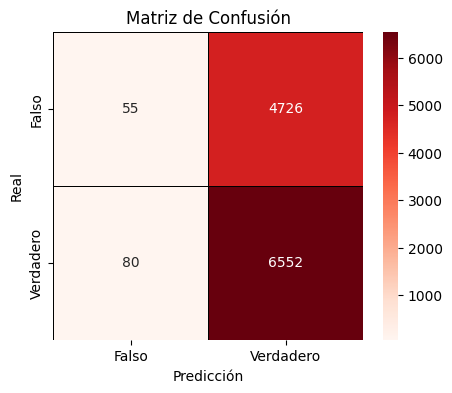

In [ ]:
def plot_confusion_matrix(conf_matrix, labels=['Falso', 'Verdadero']):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='black')

    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(matrix_nueva)

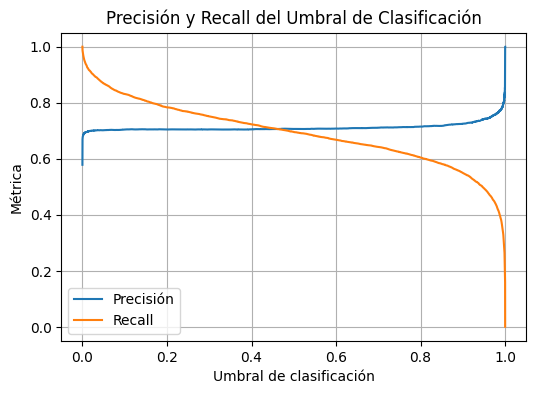

In [ ]:
y_prob_nuevo = pipeline_neural_net.predict_proba(X_test)[:, 1]
precisions_nn, recalls_nn, thresholds_nn = precision_recall_curve(y_test, y_prob_nuevo)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(thresholds_nn, precisions_nn[:-1], label="Precisión")
plt.plot(thresholds_nn, recalls_nn[:-1], label="Recall")
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.legend()
plt.title("Precisión y Recall del Umbral de Clasificación")
plt.grid()
plt.show()

El punto de equilibrio se encuentra entre 0.4 y 0.5, por lo que nuestro nuevo umbral va a ser de 0.4

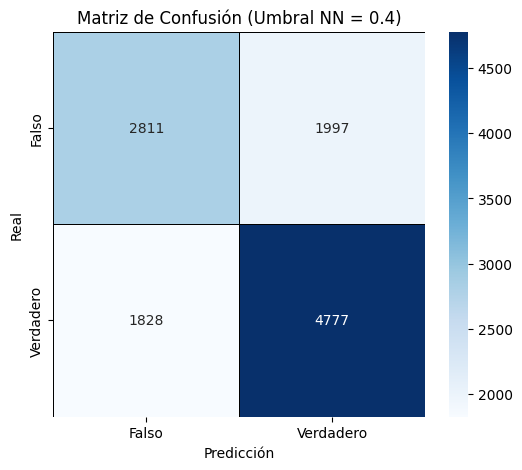

Exactitud con nuevo umbral: 0.6649

Nueva Matriz de Confusión:
[[2811 1997]
 [1828 4777]]

Nuevo Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.61      0.58      0.60      4808
           1       0.71      0.72      0.71      6605

    accuracy                           0.66     11413
   macro avg       0.66      0.65      0.65     11413
weighted avg       0.66      0.66      0.66     11413



In [ ]:
n_umbral = 0.4

y_nuevo = (y_prob_nuevo >= n_umbral).astype(int)

matrix_nuevo = confusion_matrix(y_test, y_nuevo)

plt.figure(figsize=(6, 5))
sns.heatmap(matrix_nuevo, annot=True, fmt='d', cmap='Blues', xticklabels=['Falso', 'Verdadero'],
            yticklabels=['Falso', 'Verdadero'], linewidths=0.5, linecolor='black')

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión (Umbral NN = {n_umbral})')
plt.show()

accuracy_nuevo_nn = accuracy_score(y_test, y_nuevo)
classification_rep_nuevo_nn = classification_report(y_test, y_nuevo)

print(f"Exactitud con nuevo umbral: {accuracy_nuevo_nn:.4f}")
print("\nNueva Matriz de Confusión:")
print(matrix_nuevo)
print("\nNuevo Reporte de Clasificación:")
print(classification_rep_nuevo_nn)

El nuevo umbral de 0.4 reduce los falsos positivos, lo que mejora la precisión al clasificar noticias falsas, pero también aumenta los falsos negativos, lo que significa que más noticias falsas son clasificadas incorrectamente como verdaderas.

**3.2.1** **Entrenamiento**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

arbol = DecisionTreeClassifier(criterion='entropy', max_depth = 4, random_state = 0)
arbol

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
arbol.fit(X_train_tfidf, y_train)
y_pred = arbol.predict(tfidf_vectorizer.transform(X_test))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Primer arbol

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [ ]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred)))
print("Precisión: {}".format(precision_score(y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

print("\nReporte de Clasificación:")
print(classification_rep)

Exactitud: 0.67
Recall: 0.954882664647994
Precisión: 0.6423261024544251
Puntuación F1: 0.7680224062347784

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.27      0.40      4808
           1       0.64      0.95      0.77      6605

    accuracy                           0.67     11413
   macro avg       0.73      0.61      0.59     11413
weighted avg       0.71      0.67      0.62     11413



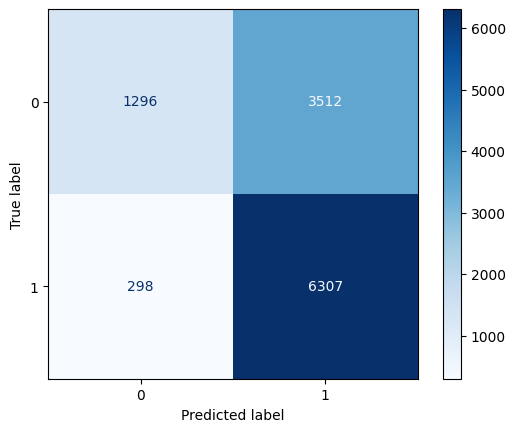

In [ ]:
matriz = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

3.2.2 Ajuste de hiperparametros


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [4, 6, 8, 10, 20]
}

modelo = GridSearchCV(pipeline, param_grid, cv=5)
modelo.fit(X_train, y_train)
print(modelo.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extr

{'classifier__criterion': 'entropy', 'classifier__max_depth': 8}


Se prueba el modelo con el test

In [ ]:
a_fin = modelo.best_estimator_
y_pred_train = a_fin.predict(X_train)
y_pred_test = a_fin.predict(X_test)
print(f'Exactitud sobre entrenamiento: {accuracy_score(y_train, y_pred_train)}')
print(f'Exactitud sobre test: {accuracy_score(y_test, y_pred_test)}')

Exactitud sobre entrenamiento: 0.7023439211391018
Exactitud sobre test: 0.689915009200035


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.35      0.49      4808
           1       0.66      0.94      0.78      6605

    accuracy                           0.69     11413
   macro avg       0.73      0.64      0.63     11413
weighted avg       0.72      0.69      0.66     11413



In [ ]:
arbol_def = DecisionTreeClassifier(criterion='entropy', max_depth = 20, random_state = 0)
arbol_def

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=0)

In [ ]:

arbol_def = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=0)
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
arbol_def = arbol_def.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
y_predict = arbol.predict(tfidf_vectorizer.transform(X_test))

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [ ]:
print('Exactitud: ', accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred)))
print("Precisión: {}".format(precision_score(y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

print("\nReporte de Clasificación:")
print(classification_rep)
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

print("\nReporte de Clasificación:")
print(classification_rep)

Exactitud:  0.6661701568386927
Recall: 0.954882664647994
Precisión: 0.6423261024544251
Puntuación F1: 0.7680224062347784

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.27      0.40      4808
           1       0.64      0.95      0.77      6605

    accuracy                           0.67     11413
   macro avg       0.73      0.61      0.59     11413
weighted avg       0.71      0.67      0.62     11413

Puntuación F1: 0.7680224062347784

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.27      0.40      4808
           1       0.64      0.95      0.77      6605

    accuracy                           0.67     11413
   macro avg       0.73      0.61      0.59     11413
weighted avg       0.71      0.67      0.62     11413



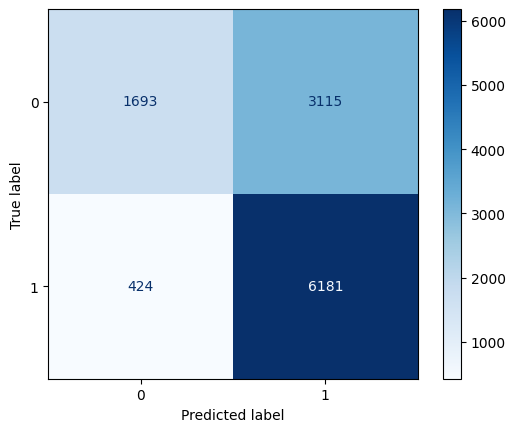

In [ ]:
nueva_m = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=nueva_m, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()


Se puede ver que el nuevo arbol con hipervisores tienen valores muy similares para bajar el numero de falsos positivos. Por lo que implementar este algoritmo no es valido para lo que necesitamos y comparandolo con los demas es muy poco funcional

# 3.3 Juan Manuel Ramírez Tamayo
**Algoritmo de Naive Bayes**

En esta sección, se implementó el algoritmo de naive bayes mediante scikit-learn y su documentación. Se prepararon los datos tranformados teniendo en cuenta el entrenamiendo del modelo con los diferentes valores del alpha y evaluando con el modelo utilizado donde se usaron métricas de rendimiento como la precisión, el recall, el F1-score, etc.

### Matriz de confusión:

Matriz de confusión para definir el umbral

Se extraen las descripciones y etiquetas de las noticias, y se dividen en conjuntos de entrenamiento y prueba. Posteriormente se crea un pipeline que transforma los textos en una representación numérica mediante 'tfidf' y aplica el clasificador MultinomialNB.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

X = news_df['Descripcion']
y = news_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_naive_bayes = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)),
    ('classifier', MultinomialNB())
])

pipeline_naive_bayes.fit(X_train, y_train)

y_pred_NB = pipeline_naive_bayes.predict(X_test)

cm = confusion_matrix(y_test, y_pred_NB)

KeyError: 'Label'

Este código genera una visualización gráfica de la matriz de confusión obtenida al evaluar el modelo Naive Bayes la cual se muestra de la siguiente manera en cuadros y los valores que representa cada uno.

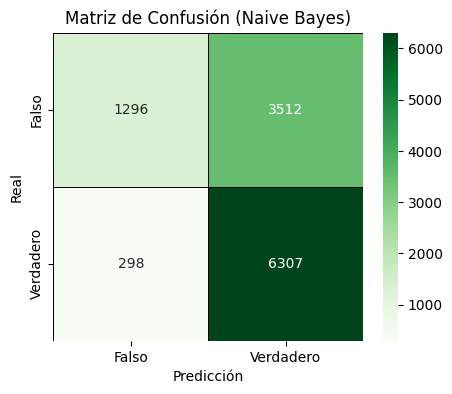

In [ ]:
from sklearn.metrics import confusion_matrix

matrix_nueva = confusion_matrix(y_test, y_pred, labels=[0, 1])

def plot_confusion_matrix_nb(conf_matrix, labels=['Falso', 'Verdadero']):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels,
                linewidths=0.5, linecolor='black')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión (Naive Bayes)')
    plt.show()

plot_confusion_matrix_nb(matrix_nueva)


Mediante este código se calculan las probabilidades de la clase positiva en el conjunto de prueba A dnde se obtienen las curvas de precisión y recall siendo graficadas, dando la posibilidad de evaluar cómo van variando estas métricas en función del umbral de desición.

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


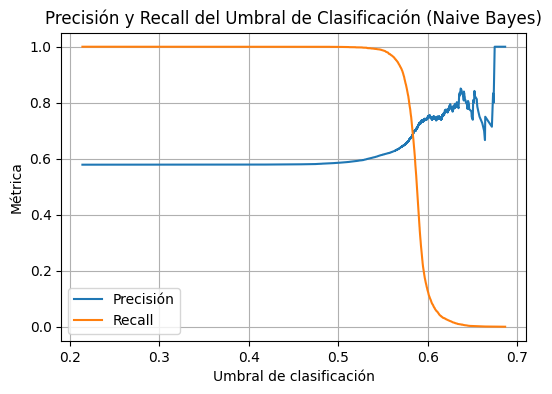

In [ ]:
pipeline_naive_bayes.fit(X_train, y_train)

y_prob_nb = pipeline_naive_bayes.predict_proba(X_test)[:, 1]

precisions_nb, recalls_nb, thresholds_nb = precision_recall_curve(y_test, y_prob_nb)

plt.figure(figsize=(6, 4))
plt.plot(thresholds_nb, precisions_nb[:-1], label="Precisión")
plt.plot(thresholds_nb, recalls_nb[:-1], label="Recall")
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.legend()
plt.title("Precisión y Recall del Umbral de Clasificación (Naive Bayes)")
plt.grid()
plt.show()

El punto de equilibrio se encuentra en el valor intermedio de umbral 0.5

Se genera la matriz de confusión para proporcionar una visión clara de las predicciones que resultaron correctas (verdaderos positivos y negativos) y los errores presentados (falsos positivos y negativos).

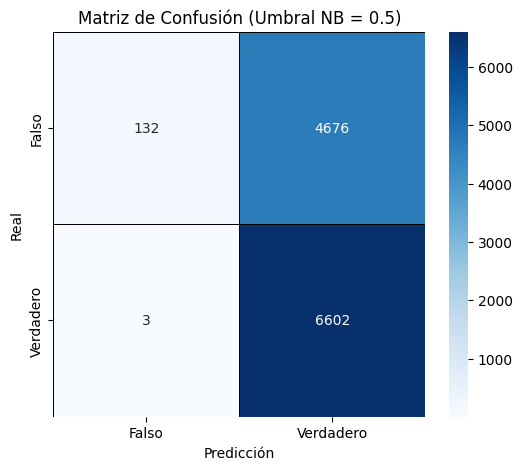

Exactitud con nuevo umbral: 0.5900

Nueva Matriz de Confusión:
[[ 132 4676]
 [   3 6602]]

Nuevo Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.03      0.05      4808
           1       0.59      1.00      0.74      6605

    accuracy                           0.59     11413
   macro avg       0.78      0.51      0.40     11413
weighted avg       0.75      0.59      0.45     11413



In [ ]:
n_umbral = 0.5

y_nuevo = (y_prob_nb >= n_umbral).astype(int)

matrix_nuevo = confusion_matrix(y_test, y_nuevo)

plt.figure(figsize=(6, 5))
sns.heatmap(matrix_nuevo, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Falso', 'Verdadero'],
            yticklabels=['Falso', 'Verdadero'],
            linewidths=0.5, linecolor='black')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión (Umbral NB = {n_umbral})')
plt.show()

accuracy_nuevo_nb = accuracy_score(y_test, y_nuevo)
classification_rep_nuevo_nb = classification_report(y_test, y_nuevo)

print(f"Exactitud con nuevo umbral: {accuracy_nuevo_nb:.4f}")
print("\nNueva Matriz de Confusión:")
print(matrix_nuevo)
print("\nNuevo Reporte de Clasificación:")
print(classification_rep_nuevo_nb)

Métricas de rendimiento


In [ ]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_NB))
print("Recall: {}".format(recall_score(y_test,y_pred_NB, average='weighted')))
print("Precisión: {}".format(precision_score(y_test,y_pred_NB, average='weighted')))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred_NB, average='weighted')))

Exactitud: 0.59
Recall: 0.5900289143958644
Precisión: 0.7506913047650505
Puntuación F1: 0.4498049301960052


In [ ]:
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

           0       0.98      0.03      0.05      4808
           1       0.59      1.00      0.74      6605

    accuracy                           0.59     11413
   macro avg       0.78      0.51      0.40     11413
weighted avg       0.75      0.59      0.45     11413



3.3.1 Entrenamiento

In [ ]:
nb = MultinomialNB(alpha=0.1, fit_prior=True)
nb

MultinomialNB(alpha=0.1)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(tfidf_vectorizer.transform(X_test))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Clasificación probabilística

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [ ]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Precisión: {}".format(precision_score(y_test, y_pred)))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred)))

print("\nReporte de Clasificación:")
print(classification_rep)


Exactitud: 0.59
Recall: 0.9995457986373959
Precisión: 0.5853874800496542
Puntuación F1: 0.7383548621595929

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.03      0.05      4808
           1       0.59      1.00      0.74      6605

    accuracy                           0.59     11413
   macro avg       0.78      0.51      0.40     11413
weighted avg       0.75      0.59      0.45     11413



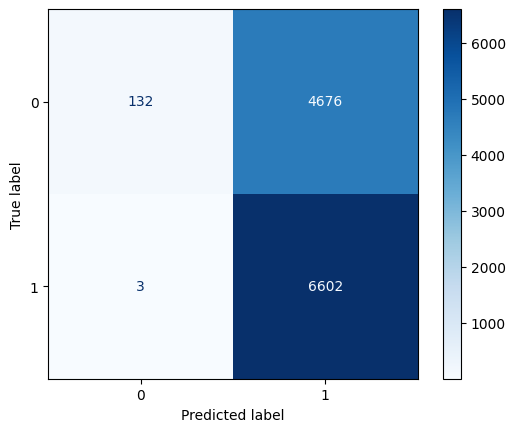

In [ ]:
matriz = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=nb.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

3.3.2 Ajuste de hiperparametros

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)),
    ('classifier', MultinomialNB())
])

param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0, 2.0]
}

modelo = GridSearchCV(pipeline, param_grid, cv=5)
modelo.fit(X_train, y_train)
print(modelo.best_params_)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extr

{'classifier__alpha': 0.1}


Prueba del modelo


In [ ]:
a_fin = modelo.best_estimator_
y_pred_train = a_fin.predict(X_train)
y_pred_test = a_fin.predict(X_test)
print(f'Exactitud sobre entrenamiento: {accuracy_score(y_train, y_pred_train)}')
print(f'Exactitud sobre test: {accuracy_score(y_test, y_pred_test)}')


Exactitud sobre entrenamiento: 0.5931872946330777
Exactitud sobre test: 0.5906422500657146


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.42      0.01      0.02      4781
           1       0.58      0.99      0.73      6632

    accuracy                           0.58     11413
   macro avg       0.50      0.50      0.38     11413
weighted avg       0.52      0.58      0.44     11413



In [ ]:
nb_def = MultinomialNB(alpha=0.1, fit_prior=True)
nb_def

MultinomialNB(alpha=0.1)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
nb_def = MultinomialNB(alpha=1.0)
nb_def = nb_def.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
y_predict = nb_def.predict(tfidf_vectorizer.transform(X_test))

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [ ]:
print('Exactitud: ', accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred)))
print("Precisión: {}".format(precision_score(y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

print("\nReporte de Clasificación:")
print(classification_rep)
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

print("\nReporte de Clasificación:")
print(classification_rep)

Exactitud:  0.5900289143958644
Recall: 0.9995457986373959
Precisión: 0.5853874800496542
Puntuación F1: 0.7383548621595929

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.03      0.05      4808
           1       0.59      1.00      0.74      6605

    accuracy                           0.59     11413
   macro avg       0.78      0.51      0.40     11413
weighted avg       0.75      0.59      0.45     11413

Puntuación F1: 0.7383548621595929

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.03      0.05      4808
           1       0.59      1.00      0.74      6605

    accuracy                           0.59     11413
   macro avg       0.78      0.51      0.40     11413
weighted avg       0.75      0.59      0.45     11413



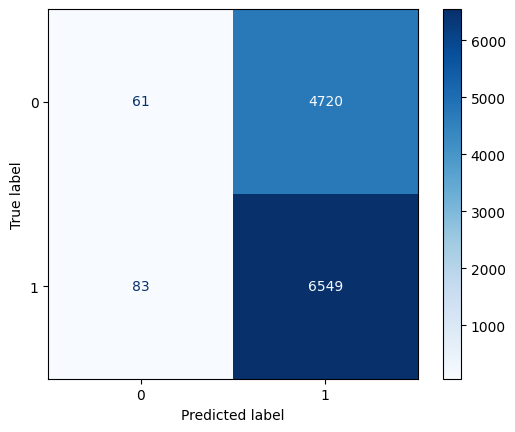

In [ ]:
nueva_m = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=nueva_m, display_labels=nb_def.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 4 Resultados

Se implementaron los algoritmos de KNN, Árboles de desición y Naive Bayes

En los tres algoritmos se implementaron matrices de confusión con 4 cuadros para definir en cuando se generaron las predicciones correctas (verdaderos positivos y negativos) y los errores cometidos (falsos positivos y negativos).

Se evaluaron otras métricas de rendimiento como la precisión, el recall y la puntuación F1 que brindo la posibilidad de facilitar una comparación cuantitativa del desempeño de cada modelo. De la misma fora que se analizaron las curvas ROC y Precision-Recall para observar cómo varían estas métricas al modificar el umbral de clasificación.

- KNN fue más eficiente en las agrupaciones del parámetro K
- Arboles de Desición fue más eficiente en las reglas de decisión
- Naive bayes fue más eficiente la clasificación de los datos en el enfoque probabilístico.

A partir de las tres matrices de confusión mostradas (KNN, Árboles de Decisión y Naive Bayes), podemos comparar en detalle tanto la exactitud general como el balance entre falsos positivos y falsos negativos. A continuación, se presenta un análisis punto por punto:

#### KNN (k=9)

- Verdaderos Negativos: 1870
- Falsos Positivos: 2938
- Falsos Negativos: 1954
- Verdaderos Positivos: 4651

La cantidad de falsos positivos y negativos es un poco equilibrada, por lo tanto KNN comete errores de ambos tipos de una forma similar.

- Datos totales = 11413
- Exactitud aproximada -> (1870+4561)/11413 ≈ 57,1%

#### Árbol de desición

- Verdaderos Negativos: 132
- Falsos Positivos: 4676
- Falsos Negativos: 3
- Verdaderos Positivos: 6602

La cantidad de falsos positivos y negativos es extremadamente dispar, por lo tanto árboles de decisión comete muchos más errores de un tipo de que otro.

- Datos totales = 11413
- Exactitud aproximada -> (132+6602)/11413 ≈ 59,0%

#### Naive Bayes

- Verdaderos Negativos: 1296
- Falsos Positivos: 3512
- Falsos Negativos: 298
- Verdaderos Positivos: 6307

La cantidad de falsos positivos y negativos es extremadamente dispar, por lo tanto naive bayes comete muchos más errores de un tipo de que otro.

- Datos totales = 11413
- Exactitud aproximada -> (1296+6307)/11413 ≈ 66,6%

### Recall

#### KNN (k=9)

- Falsos Negativos: 1954
- Verdaderos Positivos: 4651

- Recall -> 4651/(4651+1954) ≈ 70,4%

#### Árbol de desición

- Falsos Negativos: 3
- Verdaderos Positivos: 6602

- Recall -> 6602/(6602+3) ≈ 99,9%

#### Naive Bayes


- Falsos Negativos: 298
- Verdaderos Positivos: 6307

- Recall -> 6307/(6307+298) ≈ 95,5%

El recall es muy importante en los contextos donde es crítico detectar la mayor cantidad de noticias falsas, aunque sebe evaluar el balance con precisión entre detectar correctaente las noticias que son falsas y evitar que se clasifiquen erróneamente.




# 5 Predicciones

In [ ]:
news_df = pd.read_csv('fake_news_test_copy.csv', sep=';', encoding="ISO-8859-1", on_bad_lines='skip')

if 'Label' not in news_df.columns:
    print("Error: The 'Label' column is not found in the DataFrame.")

else:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    import nltk
    nltk.download('stopwords')
    stop_words = set(stopwords.words('spanish'))

    X = news_df['Descripcion']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize,
                                       stop_words=list(stop_words),
                                       lowercase=True)

    tfidf_vectorizer.fit(X_train)

    print(f'Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}')
    tfidf_model_best = RandomForestClassifier(random_state=7)

    X_tfidf = tfidf_vectorizer.transform(X_train)

Error: The 'Label' column is not found in the DataFrame.


In [ ]:
import pandas as pd

data_new = pd.read_csv('/content/fake_news_test_copy.csv', sep=';', encoding="ISO-8859-1", on_bad_lines='skip')